In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
# mpl.use('Cairo')  # for saving SVGs that Affinity Designer can parse
import matplotlib.pyplot as plt
import seaborn as sns
import dill

import jax.numpy as jnp

import candas as can
import pathlib as pl

code_pth = pl.Path.cwd()  # for running in Jupyter
# code_pth = pl.Path(__file__)  # for running in terminal
fig_pth = code_pth.parent
data_pth = fig_pth / 'data'
graph_pth = fig_pth / 'graphics'
graph_pth.mkdir(exist_ok=True)

gen_pth = fig_pth / 'generated'
gen_pth.mkdir(exist_ok=True)

plt.style.use(str(can.style.breve))

%config InlineBackend.figure_format = 'retina'

In [2]:
# from utils import savefig

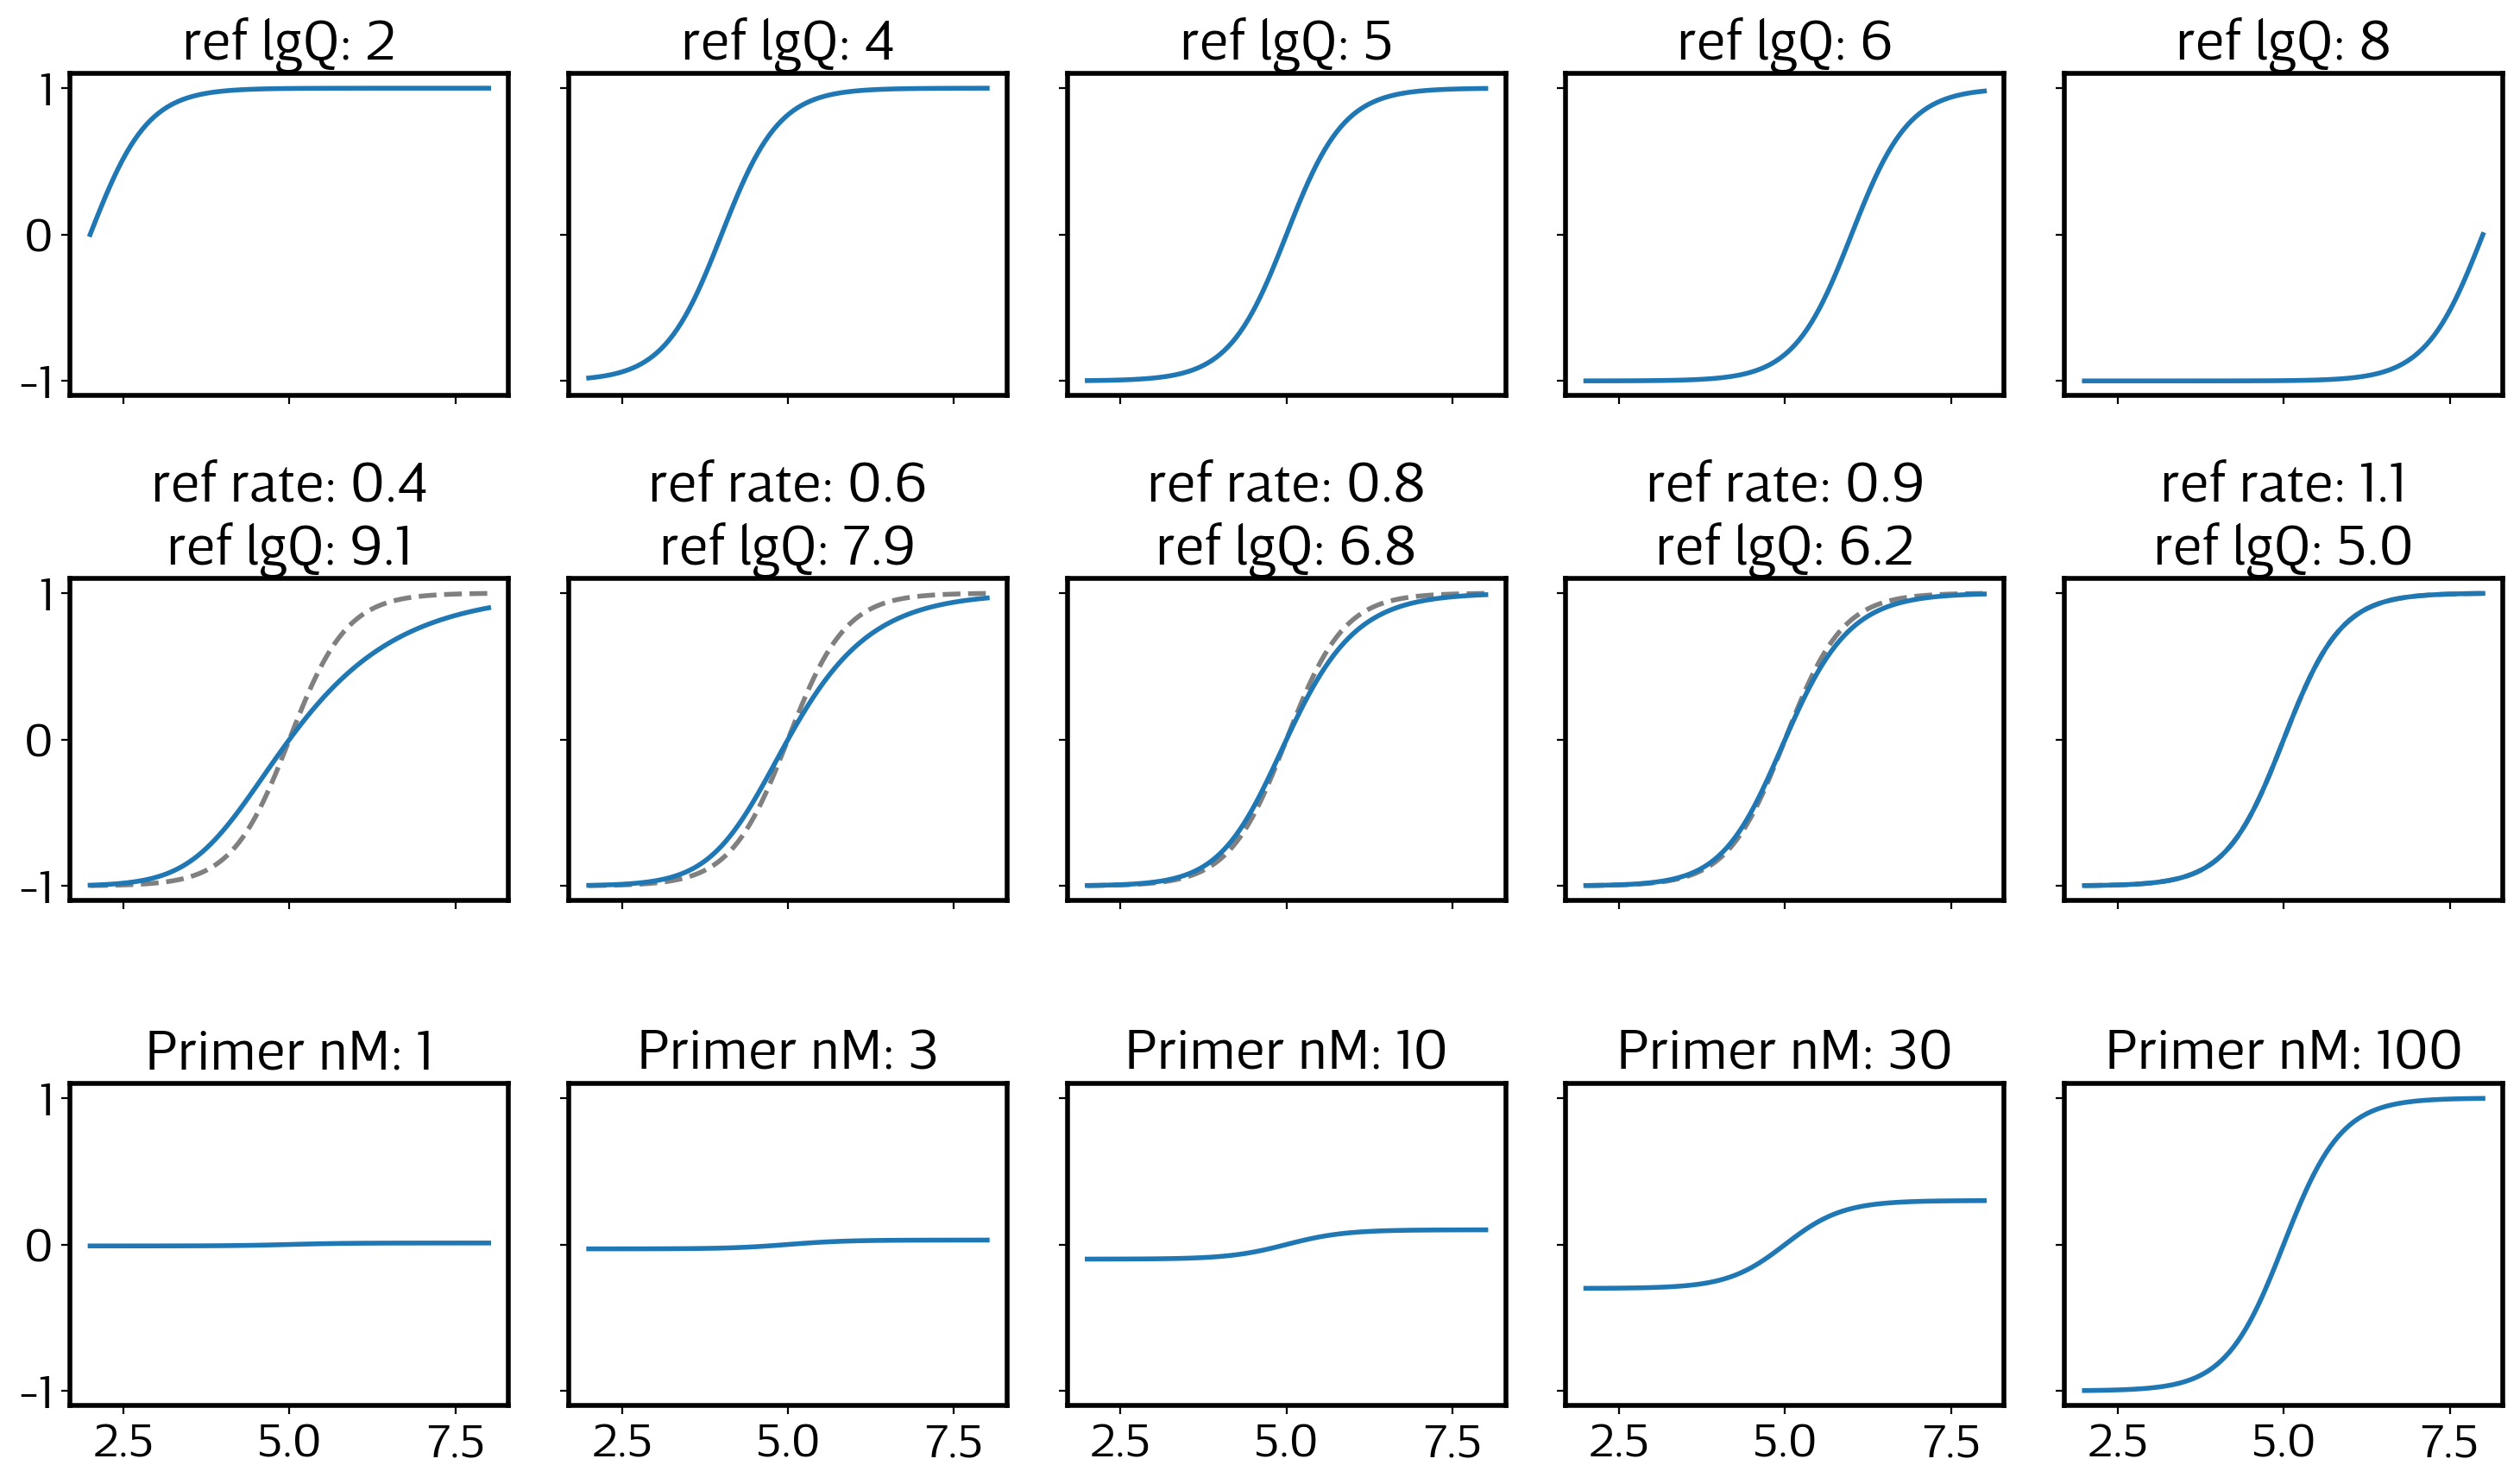

In [3]:
target = np.array([[-1, +1]])
competitor = np.array([[-1, +1]])

positive_labels = np.array([[1, 0, 0, 0], [0, 0, 1, 0]])

rxn_b = can.models.CAN(
    target,
    competitor,
    positive_labels,
    INT_names=["WT"],
    EXT_names=["REF"],
    label_names=["H", "F"],
)

rxn_b.n_cycles = 50
rxn_b.compile()


def sym_bipartite(
    ref_rate,
    ref_lgQ,
    wt_rate=0.9,
    wt_start=2,
    wt_end=8,
    n_points=100,
    ref_drift=0,
    wt_drift=0,
):

    rxn_b.oligo("WT").rate = wt_rate
    rxn_b.oligo("REF").rate = ref_rate

    rxn_b.oligo("WT").drift = wt_drift
    rxn_b.oligo("REF").drift = ref_drift

    rxn_b.oligo("REF").copies = 10**ref_lgQ

    wt_lgQ = np.linspace(wt_start, wt_end, n_points)

    arrays = [wt_lgQ]
    grids = jnp.meshgrid(*arrays)
    pts = jnp.vstack([grid.ravel() for grid in grids]).T

    rxn_b.sweep_setup = arrays, grids, pts, rxn_b.INT_idxs
    sol = rxn_b.solution_sweep()
    return wt_lgQ, sol


axs = plt.subplots(3, 5, figsize=(15, 9), sharex=True, sharey=True)[1]

row = axs[0]
ref_rate = 0.9

for ax, ref_lgQ in zip(row, [2, 4, 5, 6, 8]):
    wt_lgQ, sol = sym_bipartite(ref_rate=ref_rate, ref_lgQ=ref_lgQ)
    ax.plot(wt_lgQ, sol)
    ax.set_title(f"ref lgQ: {ref_lgQ}")

row = axs[1]
ref_lg = 5.0



def ref_lgQ_loss(ref_lgQ, ref_rate=0.9, wt_rate=1.1, wt_lgQ=5.0):

    rxn_b.oligo("WT").rate = wt_rate
    rxn_b.oligo("REF").rate = ref_rate
    rxn_b.oligo("WT").drift = 0
    rxn_b.oligo("REF").drift = 0
    rxn_b.oligo("REF").copies = 10**ref_lgQ
    rxn_b.oligo("WT").copies = 10**wt_lgQ

    rxn_b.setup_solution_sweep(rng=[wt_lgQ, wt_lgQ], res=1)
    rxn_b.sweep_setup
    loss = np.array(rxn_b.solution_sweep())[0] ** 2

    return loss

from scipy.optimize import minimize_scalar

_, mid_sol = wt_lgQ, sol = sym_bipartite(wt_rate=1.1, ref_rate=1.1, ref_lgQ=5.0)
for ax, rate, ref_lgQ in zip(row, [0.4, 0.6, 0.8, 0.9, 1.1], [6.5, 6.0, 5, 4, 3]):
    ref_lgQ = minimize_scalar(
        ref_lgQ_loss, args=(rate, 1.1), bounds=(-1, 11), method="bounded"
    ).x
    wt_lgQ, sol = sym_bipartite(wt_rate=1.1, ref_rate=rate, ref_lgQ=ref_lgQ)
    ax.plot(wt_lgQ, mid_sol, ls="--", color="gray")
    ax.plot(wt_lgQ, sol)
    ax.set_title(f"ref rate: {rate}\nref lgQ: {ref_lgQ:.1f}")
    
row = axs[2]
ref_lgQ = 5.0
ref_rate = 0.8
wt_rate = 0.8
for ax, nM in zip(row, [1, 3, 10, 30, 100]):
    rxn_b.primer_nMs = [nM, nM]
    wt_lgQ, sol = sym_bipartite(
        wt_rate=wt_rate, ref_rate=ref_rate, ref_lgQ=ref_lgQ,
    )
    ax.plot(wt_lgQ, sol)
    ax.set_title(f"Primer nM: {nM}")
    
plt.tight_layout()